In [ ]:
# ------------------ check allocated GPU --------------------

# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil

import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()

# XXX: only one GPU on Colab isn’t guaranteed
gpu = GPUs[0]
def printm():
  process = psutil.Process(os.getpid())
  print("Gen RAM Free: " + humanize.naturalsize(psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))

printm()

# IMPORTS #

In [ ]:
# import the necessary packages
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import GlobalMaxPooling2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import multiply
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Permute
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import add

from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.callbacks import *
from tensorflow.keras.regularizers import l2, Regularizer
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import backend as K
from tensorflow import keras

from tensorflow.keras.losses import CategoricalCrossentropy, sparse_categorical_crossentropy
from tensorflow.keras.optimizers import SGD

from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import tempfile
import json
import time
import cv2
import os

In [ ]:
! mkdir models

# CUSTOM REGULARIZER #

In [ ]:
class SimilarityPenalizer(Regularizer):
    def __init__(self, lamb, l2_reg):
        super(SimilarityPenalizer, self).__init__()
        self.lamb = lamb
        self.l2_reg = l2_reg
    
    def __call__(self, x):
        # x_copy = x

        # x = tf.reshape(x, (-1, x.shape[-1]))
        # mu = tf.math.reduce_mean(x, axis = 0, keepdims = True)

        # x_ = x - mu
        # x_ = tf.reshape(x_, (x_.shape[0], x_.shape[1], 1))
        # x_ = tf.repeat(x_, x_.shape[1], axis = -1)

        # C  = (1 / x_.shape[0]) * tf.reduce_sum(tf.multiply(x_, tf.transpose(x_, perm = (0, 2, 1))), axis = 0)

        # dist = (1 / 2) * (tf.norm(C) - tf.norm(tf.linalg.diag_part(C)))

        # return ((self.lamb * dist) + (self.l2_reg * tf.math.reduce_sum(tf.math.square(x_copy))))

        x_copy = x
        
        x = tf.reshape(x, (x.shape[-1], -1))
        x = x / (tf.linalg.norm(x, axis = -1, keepdims = True))
        cs = tf.matmul(x, tf.transpose(x))
        cs = cs * (1.0 - tf.eye(cs.shape[0], dtype = cs.dtype))

        dist = tf.reduce_sum(tf.math.log(1.0 + tf.exp(10.0 * (cs - 1.0))))

        return (tf.cast((self.lamb * dist), tf.float32) + (self.l2_reg * tf.math.reduce_sum(tf.math.square(x_copy))))
    
    def get_config(self):
        return {"lamb" : float(self.lamb),
                "l2_reg" : float(self.l2_reg)}

In [ ]:
class ActivityRegularizer(Regularizer):
    def __init__(self, lamb):
        super(ActivityRegularizer, self).__init__()
        self.lamb = lamb
    
    def __call__(self, x):
        x_ = tf.reduce_mean(x, axis = (1, 2))
        x_ = tf.reshape(x_, (-1, x_.shape[1], 1))
        x_ = tf.repeat(x_, x_.shape[-2], axis = -1)

        dist = tf.reduce_mean(tf.abs(tf.subtract(x_, tf.transpose(x_, perm = (0, 2, 1)))))

        return (self.lamb / dist)

    def get_config(self):
        return {"lamb" : self.lamb}

In [ ]:
class NegReg(Regularizer):
    def __init__(self, reg, eta, l2_reg):
        super(NegReg, self).__init__()
        self.reg = reg
        self.eta = eta
        self.l2_reg = l2_reg
        print(self.eta)
    
    def __call__(self, x):
        x_copy = x

        x = tf.reshape(x, (x.shape[-1], -1))
        x = x / tf.linalg.norm(x, axis = -1, keepdims = True)
        cs = tf.matmul(x, tf.transpose(x))
        cs = cs - self.eta * (tf.eye(cs.shape[0], dtype = cs.dtype) - tf.ones_like(cs, dtype = cs.dtype))

        cs = cs * (1 - tf.eye(cs.shape[0], dtype = cs.dtype))
        dist = (1 / 2.0) * tf.reduce_sum(tf.math.square(cs))

        return (tf.cast((self.reg * dist), tf.float32) + (self.l2_reg * tf.math.reduce_sum(tf.math.square(x_copy))))
    
    def get_config(self):
        return {"reg" : self.reg,
                "eta" : self.eta,
                "l2_reg" : self.l2_reg}

# CUSTOM LAYERS #

In [ ]:
class Mish(Layer):
    '''
    Mish Activation Function.
    .. math::
        mish(x) = x * tanh(softplus(x)) = x * tanh(ln(1 + e^{x}))
    Shape:
        - Input: Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a model.
        - Output: Same shape as the input.
    Examples:
        >>> X_input = Input(input_shape)
        >>> X = Mish()(X_input)
    '''

    def __init__(self, **kwargs):
        super(Mish, self).__init__(**kwargs)
        self.supports_masking = True

    def call(self, inputs):
        return inputs * K.tanh(K.softplus(inputs))

    def get_config(self):
        config = super(Mish, self).get_config()
        return config

    def compute_output_shape(self, input_shape):
        return input_shape

In [ ]:
class Repeat(Layer):
    def __init__(self, **kwargs):
        super(Repeat, self).__init__(**kwargs)
    
    def call(self, x):
        return K.repeat(x, x.shape[-1])

In [ ]:
class Dist(Layer):
    def __init__(self, **kwargs):
        super(Dist, self).__init__(**kwargs)
    
    def call(self, x):
        return tf.math.reduce_mean(tf.math.abs(tf.math.subtract(x, tf.transpose(x, perm = [0, 2, 1]))), axis = -1)

In [ ]:
class Shift(Layer): 
    def __init__(self, **kwargs):
        super(Shift, self).__init__(**kwargs)
    
    def build(self, input_shape):
        # self.kernel = self.add_weight("kernel", shape = [input_shape[1][1]])
        pass
        
    def call(self, x):
        orig_shape = tf.shape(x[0])
        x[0] = tf.reshape(x[0], (orig_shape[0], orig_shape[-1], -1))
        norms = tf.linalg.norm(x[0], axis = -1, keepdims = True)

        shift = x[0] - x[1]
        shift = shift / (tf.linalg.norm(shift, axis = -1, keepdims = True) + 1e-6)

        return tf.reshape(tf.multiply(shift, norms), orig_shape)

In [ ]:
class Grad(Layer):
    def __init__(self, lambd = 10.0, eps = 1e-6, **kwargs):
        super(Grad, self).__init__(**kwargs)
        self.lambd = lambd
        self.eps = eps
    
    def build(self, input_shape):
        self.kernel = self.add_weight("kernel", shape = [1, input_shape[-1], 1])
    
    def call(self, x):
        shape = tf.shape(x)
        x = tf.reshape(x, (shape[0], shape[-1], -1))
        norms = tf.linalg.norm(x, axis = -1, keepdims = True)
        xn = x / (norms + 1e-6)
        grad = tf.matmul(xn, tf.transpose(xn, perm = (0, 2, 1)))
        grad = (grad * self.lambd) / (grad + tf.exp(self.lambd))
        grad = grad * (1 - tf.eye(tf.shape(grad)[1], dtype = grad.dtype))
        grad = tf.matmul(grad, xn)
        grad = grad / (tf.linalg.norm(grad, axis = -1, keepdims = True) + 1e-6)
        grad *= tf.math.square(self.kernel)

        return grad
    
    def get_config(self):
        return {"lambd" : self.lambd, "eps" : self.eps}

In [ ]:
class RadialShift(Layer):
    def __init__(self, **kwargs):
        super(RadialShift, self).__init__(**kwargs)
    
    def call(self, x):
        mu = tf.reduce_mean(x, axis = -1, keepdims = True)
        return x - mu

# BLUR POOL LAYER #


In [ ]:
class Downsample(Layer):
    def __init__(self, filt_size = 3, stride = 2, pad_off = 0, **kwargs):
        super(Downsample, self).__init__(**kwargs)
        self.filt_size = filt_size
        self.stride = stride
        self.pad_off = pad_off

        # pad sizes: LEFT, RIGHT, TOP, BOTTOM
        self.pad_sizes = [int(1. * (filt_size - 1) / 2), int(np.ceil(1. * (filt_size - 1) / 2)), int(1. * (filt_size - 1) / 2), int(np.ceil(1. * (filt_size - 1) / 2))]
        self.pad_sizes = [pad_size + pad_off for pad_size in self.pad_sizes]

    def build(self, input_shape):
        # initialize the appropriate blur kernel
        if(self.filt_size == 1):
            a = np.array([1.,])
        elif(self.filt_size == 2):
            a = np.array([1., 1.])
        elif(self.filt_size == 3):
            a = np.array([1., 2., 1.])
        elif(self.filt_size == 4):    
            a = np.array([1., 3., 3., 1.])
        elif(self.filt_size == 5):    
            a = np.array([1., 4., 6., 4., 1.])
        elif(self.filt_size == 6):    
            a = np.array([1., 5., 10., 10., 5., 1.])
        elif(self.filt_size == 7):
            a = np.array([1., 6., 15., 20., 15., 6., 1.])
        
        # compute the outer product to get the final filter
        filt = np.outer(a, a)
        filt = filt / np.sum(filt)

        # kernel shape
        kernel_shape = (self.filt_size, self.filt_size, input_shape[3], 1)

        # reshape the filter into the appropriate shape and create the initializer
        filt = np.repeat(filt, input_shape[3])
        filt = np.reshape(filt, kernel_shape)
        blur_init = keras.initializers.constant(filt)

        # create the blur kernel
        self.kernel = self.add_weight("kernel", shape = kernel_shape, initializer = blur_init, trainable = False)

        # call the parent class constructor
        super(Downsample, self).build(input_shape)
    
    def call(self, x):
        if self.filt_size == 1:
            if self.pad_off == 0:
                return x[:, ::self.stride, ::self.stride, :]
            else:
                x = tf.pad(x, paddings = tf.constant([[0, 0], self.pad_sizes[2:], self.pad_sizes[:2], [0, 0]]), mode = "REFLECT")
                return x[:, ::self.stride, ::self.stride, :]
        else:
            # pad the input (reflect pad)
            x = tf.pad(x, paddings = tf.constant([[0, 0], self.pad_sizes[2:], self.pad_sizes[:2], [0, 0]]), mode = "REFLECT")
            return K.depthwise_conv2d(x, self.kernel, strides = (self.stride, self.stride))
    
    def get_config(self):
        return {"filt_size" : self.filt_size,
                "stride" : self.stride,
                "pad_off" : self.pad_off}

# PREPROCESSORS #

In [ ]:
class PadPreprocessor:
    def __init__(self, pad):
        # initialize the instance variables
        self.pad = pad
    
    def preprocess(self, img):
        # return the padded image
        return np.pad(img, ((self.pad, self.pad), (self.pad, self.pad), (0, 0)))

In [ ]:
class ReflectionPadPreprocessor:
    def __init__(self, pad):
        # initialize the instance variables
        self.pad = pad
    
    def preprocess(self, img):
        # zero pad the image
        img = np.pad(img, ((self.pad, self.pad), (self.pad, self.pad), (0, 0)))

        # reflect pad the image
        for i, j in zip(range(self.pad), range(self.pad)):
            xstart = self.pad
            xend = img.shape[1] - self.pad - 1
            ystart = self.pad
            yend = img.shape[0] - self.pad - 1

            img[:, xstart - i - 1] = img[:, xstart + i + 1]
            img[:, xend + i + 1] = img[:, xend - i - 1]
            img[ystart - j - 1, :] = img[ystart + j + 1, :]         
            img[yend + j + 1, :] = img[yend - j - 1, :]   
        
        # return the processed image
        return img

In [ ]:
class FlipPreprocessor:
    def __init__(self, prob):
        # initialize the instance variables 
        self.prob = prob
    
    def preprocess(self, img):
        p = np.random.uniform(size = (1,))

        # check to see if the image is to be flipped
        if p <= self.prob:
            img = cv2.flip(img, 1)
        
        # return the processed image
        return img

In [ ]:
class PatchPreprocessor:
    def __init__(self, height, width):
        # initialize the instance variables - target height and width
        self.height = height
        self.width = width
    
    def preprocess(self, img):
        # extract a random crop from the image and return it
        return extract_patches_2d(img, (self.height, self.width), max_patches = 1)[0]

In [ ]:
class MeanPreprocessor:
    def __init__(self, mean, std, normalize = True):
        # initialize the instance variables
        self.mean = mean
        self.std = std
        self.normalize = normalize
    
    def preprocess(self, img):
        # if the image is to be normalized, normalize it
        if self.normalize:
            img = img.astype("float") / 255.0

        # return the processed image
        return ((img - self.mean) / self.std)

In [ ]:
class ImageToArrayPreprocessor:
    def __init__(self, data_format = None):
        # initialize the instance variables
        self.data_format = data_format

    def preprocess(self, img):
        # apply the keras utility function that correctly rearranges the dimensions of the image
        return img_to_array(img, data_format = self.data_format)

# DATA GENERATOR #

In [ ]:
class CifarGenerator:
    def __init__(self, x_train, y_train, batch_size, preprocessors = None, aug = None):
        # initialize the cifar data
        self.x_train = x_train
        self.y_train = y_train

        # initialize the instance variables
        self.bs = batch_size
        self.preprocessors = preprocessors
        self.aug = aug
        self.num_images = self.x_train.shape[0]
        self.lb = LabelBinarizer()
        self.lb.fit(y_train)
    
    def generator(self, passes = np.inf):
        # initialize a variable to keep a count on the epochs
        epochs = 0

        # loop through the dataset indefinitely
        while(epochs < passes):
            # initialize the indices
            indices = list(range(self.num_images))
            np.random.shuffle(indices)

            # loop through the dataset in batches
            for i in range(0, self.num_images, self.bs):
                # extract the current indices
                cur_indices = sorted(indices[i : i + self.bs])

                # grab the current batch
                x, y = self.x_train[cur_indices], self.y_train[cur_indices]

                # if any preprocessors are supplied, apply them
                if self.preprocessors is not None:
                    # loop through the images
                    proc_x = []
                    for img in x:
                        # loop through the preprocessors
                        for p in self.preprocessors:
                            img = p.preprocess(img)

                        proc_x.append(img)
                
                    # update the images
                    x = np.array(proc_x)
                
                # preprocess the labels
                y = self.lb.transform(y)

                # if any augmentation is supplied, apply it
                if self.aug is not None:
                    x, y = next(self.aug.flow(x, y, batch_size = bs))
                
                # yield the current batch
                yield x, y

In [ ]:
class MixUpCifarGenerator:
    def __init__(self, x_train, y_train, batch_size, alpha = 0.4, preprocessors = None, aug = None):
        # initialize the cifar data
        self.x_train = x_train
        self.y_train = y_train

        # initialize the instance variables
        self.bs = batch_size
        self.preprocessors = preprocessors
        self.aug = aug
        self.alpha = alpha
        self.num_images = self.x_train.shape[0]
        self.lb = LabelBinarizer()
        self.lb.fit(y_train)
    
    def generator(self, passes = np.inf):
        # initialize a variable to keep a count on the epochs
        epochs = 0

        # loop through the dataset indefinitely
        while(epochs < passes):
            # initialize the indices
            indices = list(range(self.num_images))
            np.random.shuffle(indices)

            # loop through the dataset in batches
            for i in range(0, self.num_images, self.bs):
                # extract the current indices
                cur_indices = sorted(indices[i : i + self.bs])

                # initialize the other batch of indices
                if i + self.bs < self.num_images:
                    oth_indices = list(range(i, i + self.bs))
                else:
                    oth_indices = list(range(i, self.num_images))

                # grab the data batches
                x1, y = self.x_train[cur_indices], self.y_train[cur_indices]
                x2 = self.x_train[oth_indices]

                # if any preprocessors are supplied, apply them
                if self.preprocessors is not None:
                    # loop through the images
                    proc_x1 = []
                    proc_x2 = []
                    for img1, img2 in zip(x1, x2):
                        # loop through the preprocessors
                        for p in self.preprocessors:
                            img1 = p.preprocess(img1)
                            img2 = p.preprocess(img2)

                        proc_x1.append(img1)
                        proc_x2.append(img2)
                
                    # update the images
                    x1 = np.array(proc_x1)
                    x2 = np.array(proc_x2)
                
                # randomly sample the lambda value from beta distribution.
                lamb = np.random.beta(self.alpha + 1, self.alpha, x1.shape[0])

                # remove possible duplicates
                lamb = np.maximum(lamb, 1 - lamb)

                # reshape the parameter to a suitable shape
                xlamb = lamb.reshape(-1, 1, 1, 1)

                # perform the mixup
                x = (xlamb * x1) + ((1 - xlamb) * x2)

                # preprocess the labels
                y = self.lb.transform(y)

                # if any augmentation is supplied, apply it
                if self.aug is not None:
                    x, y = next(self.aug.flow(x, y, batch_size = bs))
                
                # yield the current batch
                yield x, y

# MODELS #

In [ ]:
class XResNet:
    @staticmethod
    def residual_module(data, K, stride, chan_dim, red = False, reg = 1e-4, bn_eps = 2e-5, bn_mom = 0.9, bottleneck = True, name = "res_block"):
        # shortcut branch
        shortcut = data

        if bottleneck:
            # first bottleneck block - 1x1
            bn1 = BatchNormalization(axis = chan_dim, epsilon = bn_eps, momentum = bn_mom, name = name + "_bn1")(data)
            act1 = Activation("relu", name = name + "_relu1")(bn1)
            conv1 = Conv2D(int(K * 0.25), (1, 1), use_bias = False, kernel_regularizer = l2(reg), kernel_initializer = "he_normal", name = name + "_conv1")(act1)

            # conv block - 3x3
            bn2 = BatchNormalization(axis = chan_dim, epsilon = bn_eps, momentum = bn_mom, name = name + "_bn2")(conv1)
            act2 = Activation("relu", name = name + "_relu2")(bn2)            
            conv2 = Conv2D(int(K * 0.25), (3, 3), strides = stride, padding = "same", use_bias = False, kernel_initializer = "he_normal", kernel_regularizer = l2(reg), name = name + "_conv2")(act2)
            
            # second bottleneck block - 1x1
            bn3 = BatchNormalization(axis = chan_dim, epsilon = bn_eps, momentum = bn_mom, name = name + "_bn3")(conv2)
            act3 = Activation("relu", name = name + "_relu3")(bn3)
            conv3 = Conv2D(K, (1, 1), use_bias = False, kernel_regularizer = l2(reg), kernel_initializer = "he_normal", name = name + "_conv3")(act3)

            # if dimensions are to be reduced, apply a conv layer to the shortcut
            if red:
                shortcut = AveragePooling2D(pool_size = (2, 2), strides = stride, padding = "same", name = name + "_avg_pool")(act1)
                shortcut = Conv2D(K, (1, 1), strides = (1, 1), use_bias = False, kernel_initializer = "he_normal", kernel_regularizer = l2(reg), name = name + "_red")(shortcut)
                shortcut = BatchNormalization(name = name + "_red_bn")(shortcut)
            
            # add the shortcut and final conv
            x = add([conv3, shortcut], name = name + "_add")
        
        else:
            # conv block 1 - 3x3
            bn1 = BatchNormalization(axis = chan_dim, epsilon = bn_eps, momentum = bn_mom, name = name + "_bn1")(data)
            act1 = Activation("relu", name = name + "_relu1")(bn1)            
            conv1 = Conv2D(K, (3, 3), strides = stride, padding = "same", use_bias = False, kernel_initializer = "he_normal", kernel_regularizer = l2(reg), name = name + "_conv1")(act1)

            # conv block 2 - 3x3
            bn2 = BatchNormalization(axis = chan_dim, epsilon = bn_eps, momentum = bn_mom, name = name + "_bn2")(conv1)
            act2 = Activation("relu", name = name + "_relu2")(bn2)
            conv2 = Conv2D(K, (3, 3), padding = "same", use_bias = False,
                        kernel_initializer = "he_normal", kernel_regularizer = l2(reg), name = name + "_conv2")(act2)

            # if dimensions are to be reduced, apply a conv layer to the shortcut
            if red and stride != (1, 1):
                shortcut = AveragePooling2D(pool_size = (2, 2), strides = stride, padding = "same", name = name + "_avg_pool")(act1)
                shortcut = Conv2D(K, (1, 1), strides = (1, 1), use_bias = False, kernel_initializer = "he_normal", kernel_regularizer = l2(reg), name = name + "_red")(shortcut)
                shortcut = BatchNormalization(name = name + "_red_bn")(shortcut)

            # add the shortcut and final conv
            x = add([conv2, shortcut], name = name + "_add")      

        # return the addition as the output of the residual block
        return x

    @staticmethod
    def build(height, width, depth, classes, stages, filters, stem_type = "imagenet", bottleneck = True, reg = 1e-4, bn_eps = 2e-5, bn_mom = 0.9):
        # set the input shape
        if K.image_data_format() == "channels_last":
            input_shape = (height, width, depth)
            chan_dim = -1
        else:
            input_shape = (depth, height, width)
            chan_dim = 1

        # initialize a counter to keep count of the total number of layers in the model
        n_layers = 0
        
        # input block
        inputs = Input(shape = input_shape)

        # stem
        if stem_type is "imagenet":
            x = Conv2D(filters[0], (3, 3), strides = (2, 2), use_bias = False, padding = "same", 
                    kernel_initializer = "he_normal", kernel_regularizer = l2(reg), name = "stem_conv1")(inputs)
            x = Conv2D(filters[0], (3, 3), strides = (1, 1), use_bias = False, padding = "same", 
                    kernel_initializer = "he_normal", kernel_regularizer = l2(reg), name = "stem_conv2")(x)
            x = Conv2D(filters[0], (3, 3), strides = (1, 1), use_bias = False, padding = "same", 
                    kernel_initializer = "he_normal", kernel_regularizer = l2(reg), name = "stem_conv3")(x)
            x = MaxPooling2D(pool_size = (3, 3), strides = (2, 2), padding = "same", name = "stem_max_pool")(x)
        elif stem_type is "cifar":
            x = Conv2D(filters[0], (3, 3), use_bias = False, padding = "same", kernel_initializer = "he_normal", 
                       kernel_regularizer = l2(reg), name = "stem_conv")(inputs)

        # increment the number of layers
        n_layers += 1

        # modify the stages to suit bottleck
        if bottleneck:
            stages = [int(np.floor(st / 3)) for st in stages]
        else:
            stages = [int(np.floor(st / 2)) for st in stages]

        # loop through the stages
        for i in range(0, len(stages)):
            # set the stride value
            stride = (1, 1) if i == 0 else (2, 2)

            name = f"stage{i + 1}_res_block1"
            x = XResNet.residual_module(x, filters[i + 1], stride, chan_dim, reg = reg, red = True, bn_eps = bn_eps, bn_mom = bn_mom, bottleneck = bottleneck, name = name)

            # loop through the number of layers in the stage
            for j in range(0, stages[i] - 1):
                # apply a residual module
                name = f"stage{i + 1}_res_block{j + 2}"
                x = XResNet.residual_module(x, filters[i + 1], (1, 1), chan_dim, reg = reg, bn_eps = bn_eps, bn_mom = bn_mom, bottleneck = bottleneck, name = name)

            # increment the number of layers
            if bottleneck:
                n_layers += (3 * stages[i])
            else:
                n_layers += (2 * stages[i])
        
        # BN => RELU -> POOL
        x = BatchNormalization(axis = chan_dim, epsilon = bn_eps, momentum = bn_mom, name = "final_bn")(x)
        x = Activation("relu", name = "final_relu")(x)
        x1 = GlobalAveragePooling2D(name = "global_avg_pooling")(x)
        x2 = GlobalMaxPooling2D(name = "global_max_pooling")(x)
        x = concatenate([x1, x2], axis = -1, name = "concatenate")

        # softmax classifier
        sc = Dense(classes, kernel_initializer = "he_normal", kernel_regularizer = l2(reg), name = "classifier")(x)
        sc = Activation("softmax", name = "softmax")(sc)

        # increment the number of layers
        n_layers += 1

        print(f"[INFO] {__class__.__name__}{n_layers} built successfully!")

        # return the constructed network architecture
        return Model(inputs = inputs, outputs = sc, name = f"{__class__.__name__}{n_layers}")

In [ ]:
class MXResNet:
    @staticmethod
    def residual_module(data, K, stride, chan_dim, red = False, reg = 1e-4, bn_eps = 2e-5, bn_mom = 0.9, bottleneck = True, name = "res_block"):
        # shortcut branch
        shortcut = data

        if bottleneck:
            # first bottleneck block - 1x1
            bn1 = BatchNormalization(axis = chan_dim, epsilon = bn_eps, momentum = bn_mom, name = name + "_bn1")(data)
            act1 = Mish(name = name + "_mish1")(bn1)
            conv1 = Conv2D(int(K * 0.25), (1, 1), use_bias = False, kernel_regularizer = l2(reg), kernel_initializer = "he_normal", name = name + "_conv1")(act1)

            # conv block - 3x3
            bn2 = BatchNormalization(axis = chan_dim, epsilon = bn_eps, momentum = bn_mom, name = name + "_bn2")(conv1)
            act2 = Mish(name = name + "_mish2")(bn2)            
            conv2 = Conv2D(int(K * 0.25), (3, 3), padding = "same", use_bias = False, kernel_initializer = "he_normal", kernel_regularizer = l2(reg), name = name + "_conv2")(act2)
            
            if stride != (1, 1):
                conv2 = Downsample(filt_size = 3, stride = stride[0], name = name + "_downsample")(conv2)
            
            # second bottleneck block - 1x1
            bn3 = BatchNormalization(axis = chan_dim, epsilon = bn_eps, momentum = bn_mom, name = name + "_bn3")(conv2)
            act3 = Mish(name = name + "_mish3")(bn3)
            conv3 = Conv2D(K, (1, 1), use_bias = False, kernel_regularizer = l2(reg), kernel_initializer = "he_normal", name = name + "_conv3")(act3)

            # if dimensions are to be reduced, apply a conv layer to the shortcut
            if red:
                if stride != (1, 1):
                    shortcut = Downsample(filt_size = 3, stride = stride[0], name = name + "_avg_blur_pool")(act1)
                # shortcut = AveragePooling2D(pool_size = (2, 2), strides = stride, padding = "same", name = name + "_avg_pool")(act1)
                shortcut = Conv2D(K, (1, 1), strides = (1, 1), use_bias = False, kernel_initializer = "he_normal", kernel_regularizer = l2(reg), name = name + "_red")(shortcut)
                shortcut = BatchNormalization(name = name + "_red_bn")(shortcut)
            
            # add the shortcut and final conv
            x = add([conv3, shortcut], name = name + "_add")
        
        else:
            # conv block 1 - 3x3
            bn1 = BatchNormalization(axis = chan_dim, epsilon = bn_eps, momentum = bn_mom, name = name + "_bn1")(data)
            act1 = Mish(name = name + "_mish1")(bn1)            
            conv1 = Conv2D(K, (3, 3), padding = "same", use_bias = False, kernel_initializer = "he_normal", kernel_regularizer = l2(reg), name = name + "_conv1")(act1)

            if stride != (1, 1):
                conv1 = Downsample(filt_size = 3, stride = stride[0], name = name + "_downsample")(conv1)

            # conv block 2 - 3x3
            bn2 = BatchNormalization(axis = chan_dim, epsilon = bn_eps, momentum = bn_mom, name = name + "_bn2")(conv1)
            act2 = Mish(name = name + "_mish2")(bn2)
            conv2 = Conv2D(K, (3, 3), padding = "same", use_bias = False,
                        kernel_initializer = "he_normal", kernel_regularizer = l2(reg), name = name + "_conv2")(act2)

            # if dimensions are to be reduced, apply a conv layer to the shortcut
            if red and stride != (1, 1):
                shortcut = Downsample(filt_size = 3, stride = stride[0], name = name + "_avg_blur_pool")(act1)
                # shortcut = AveragePooling2D(pool_size = (2, 2), strides = stride, padding = "same", name = name + "_avg_pool")(act1)
                shortcut = Conv2D(K, (1, 1), strides = (1, 1), use_bias = False, kernel_initializer = "he_normal", kernel_regularizer = l2(reg), name = name + "_red")(shortcut)
                shortcut = BatchNormalization(name = name + "_red_bn")(shortcut)

            # add the shortcut and final conv
            x = add([conv2, shortcut], name = name + "_add")      

        # return the addition as the output of the residual block
        return x

    @staticmethod
    def build(height, width, depth, classes, stages, filters, stem_type = "imagenet", bottleneck = True, reg = 1e-4, bn_eps = 2e-5, bn_mom = 0.9):
        # set the input shape
        if K.image_data_format() == "channels_last":
            input_shape = (height, width, depth)
            chan_dim = -1
        else:
            input_shape = (depth, height, width)
            chan_dim = 1

        # initialize a counter to keep count of the total number of layers in the model
        n_layers = 0
        
        # input block
        inputs = Input(shape = input_shape)

        # stem
        if stem_type is "imagenet":
            x = Conv2D(filters[0], (3, 3), strides = (2, 2), use_bias = False, padding = "same", 
                    kernel_initializer = "he_normal", kernel_regularizer = l2(reg), name = "stem_conv")(inputs)
            x = MaxPooling2D(pool_size = (3, 3), strides = (1, 1), padding = "same", name = name + "_stem_max_pool")(x)
            x = Downsample(filt_size = 3, stride = 3, name = name + "_stem_downsample")(x)

            # x = MaxPooling2D(pool_size = (3, 3), strides = (2, 2), padding = "same", name = "stem_pool")(x)

        elif stem_type is "cifar":
            x = Conv2D(filters[0], (3, 3), use_bias = False, padding = "same", kernel_initializer = "he_normal", 
                       kernel_regularizer = l2(reg), name = "stem_conv")(inputs)

        # increment the number of layers
        n_layers += 1

        # modify the stages to suit bottleck
        if bottleneck:
            stages = [int(np.floor(st / 3)) for st in stages]
        else:
            stages = [int(np.floor(st / 2)) for st in stages]

        # loop through the stages
        for i in range(0, len(stages)):
            # set the stride value
            stride = (1, 1) if i == 0 else (2, 2)

            name = f"stage{i + 1}_res_block1"
            x = MXResNet.residual_module(x, filters[i + 1], stride, chan_dim, reg = reg, red = True, bn_eps = bn_eps, bn_mom = bn_mom, bottleneck = bottleneck, name = name)

            # loop through the number of layers in the stage
            for j in range(0, stages[i] - 1):
                # apply a residual module
                name = f"stage{i + 1}_res_block{j + 2}"
                x = MXResNet.residual_module(x, filters[i + 1], (1, 1), chan_dim, reg = reg, bn_eps = bn_eps, bn_mom = bn_mom, bottleneck = bottleneck, name = name)

            # increment the number of layers
            if bottleneck:
                n_layers += (3 * stages[i])
            else:
                n_layers += (2 * stages[i])
        
        # BN => RELU -> POOL
        x = BatchNormalization(axis = chan_dim, epsilon = bn_eps, momentum = bn_mom, name = "final_bn")(x)
        x = Mish(name = "final_mish")(x)
        x1 = GlobalAveragePooling2D(name = "global_avg_pooling")(x)
        x2 = GlobalMaxPooling2D(name = "global_max_pooling")(x)
        x = concatenate([x1, x2], axis = -1, name = "concatenate")

        # softmax classifier
        # x = Flatten(name = "flatten")(x)
        x = Dense(classes, kernel_initializer = "he_normal", kernel_regularizer = l2(reg), name = "classifier")(x)
        x = Activation("softmax", name = "softmax")(x)

        # increment the number of layers
        n_layers += 1

        print(f"[INFO] {__class__.__name__}{n_layers} built successfully!")

        # return the constructed network architecture
        return Model(inputs = inputs, outputs = x, name = f"{__class__.__name__}{n_layers}")

In [ ]:
class SPMXResNet:
    @staticmethod
    def rds_block(x, name = "rds_block", reg = 1e-4, lamb = 1e-3):
        # # shortcut = x
        
        # # x = GlobalAveragePooling2D(name = name + "_gap")(x)
        # # # x = Repeat(name = name + "_repeat")(x)
        # # # x = Dist(name = name + "_dist")(x)
        # # x = Dense(x.shape[1], use_bias = False, kernel_initializer = "he_normal", kernel_regularizer = l2(reg), name = name + "_dist")(x)
        # # x = Mish(name = name + "_mish")(x)
        # # x = Reshape((1, 1, x.shape[1]), name = name + "_reshape")(x)
        # # x = Shift(name = name + "_shift")([shortcut, x])

        # # dist = Conv2D(x.shape[-1], (1, 1), kernel_initializer = "he_normal", kernel_regularizer = l2(reg), name = name + "_dist_conv")(x)
        # # dist = Mish(name = name + "_dist_mish")(dist)
        # # dist = GlobalAveragePooling2D(name = name + "_dist_gap")(dist)
        # # dist = Reshape((1, 1, dist.shape[1]), name = name + "_dist_reshape")(dist)

        # dist = GlobalAveragePooling2D(name = name + "_gap")(x)
        # dist = Repeat(name = name + "_repeat")(x)
        # dist = Dist(name = name + "_dist")(x)
        # dist = Reshape((1, 1, dist.shape[1]), name = name + "_dist_reshape")(dist)

        # # dirn = Conv2D(x.shape[-1], (1, 1), kernel_initializer = "he_normal", kernel_regularizer = l2(reg), name = name + "_dirn_conv")(x)
        # # dirn = Mish(name = name + "_dirn_mish")(dirn)
        # dirn = RadialShift(name = name + "_dirn")(x)

        # x = Shift(name = name + "_shift")([x, dist, dirn])
        grad = Grad(name = name + "_grad")(x)
        x = Shift(name = name + "_shift")([x, grad])

        return x

    @staticmethod
    def residual_module(data, K, stride, chan_dim, red = False, lamb = 1e-3, reg = 1e-4, bn_eps = 2e-5, bn_mom = 0.9, bottleneck = True, name = "res_block"):
        # shortcut branch
        shortcut = data

        if bottleneck:      
            # first bottleneck block - 1x1
            bn1 = BatchNormalization(axis = chan_dim, epsilon = bn_eps, momentum = bn_mom, name = name + "_bn1")(data)
            act1 = Mish(name = name + "_mish1")(bn1)
            conv1 = Conv2D(int(K * 0.25), (1, 1), use_bias = False, kernel_regularizer = l2(reg), kernel_initializer = "he_normal", name = name + "_conv1")(act1)
            # conv1 = SPMXResNet.rds_block(conv1, name = name + "_rds1")

            # conv block - 3x3
            bn2 = BatchNormalization(axis = chan_dim, epsilon = bn_eps, momentum = bn_mom, name = name + "_bn2")(conv1)
            act2 = Mish(name = name + "_mish2")(bn2)
            conv2 = Conv2D(int(K * 0.25), (3, 3), strides = stride, padding = "same", use_bias = False,
                        kernel_initializer = "he_normal", kernel_regularizer = l2(reg), name = name + "_conv2")(act2)
            # conv2 = SPMXResNet.rds_block(conv2, name = name + "_rds2")
            
            # second bottleneck block - 1x1
            bn3 = BatchNormalization(axis = chan_dim, epsilon = bn_eps, momentum = bn_mom, name = name + "_bn3")(conv2)
            act3 = Mish(name = name + "_mish3")(bn3)
            conv3 = Conv2D(K, (1, 1), use_bias = False, kernel_regularizer = l2(reg), kernel_initializer = "he_normal", name = name + "_conv3")(act3)
            conv3 = SPMXResNet.rds_block(conv3, reg = reg, lamb = lamb, name = name + "_rds")

            # if dimensions are to be reduced, apply a conv layer to the shortcut
            if red:
                shortcut = AveragePooling2D(pool_size = (2, 2), strides = stride)(act1)
                shortcut = Conv2D(K, (1, 1), strides = (1, 1), use_bias = False, kernel_initializer = "he_normal", kernel_regularizer = l2(reg), name = name + "_red")(shortcut)
            
            # add the shortcut and final conv
            x = add([conv3, shortcut], name = name + "_add")
        
        else:
            # conv block 1 - 3x3
            bn1 = BatchNormalization(axis = chan_dim, epsilon = bn_eps, momentum = bn_mom, name = name + "_bn1")(data)
            act1 = Mish(name = name + "_mish1")(bn1)
            conv1 = Conv2D(K, (3, 3), strides = stride, padding = "same", use_bias = False,
                        kernel_initializer = "he_normal", kernel_regularizer = l2(reg), name = name + "_conv1")(act1)
            # conv1 = SPMXResNet.rds_block(conv1, name = name + "_rds1")
            
            # conv block 2 - 3x3
            bn2 = BatchNormalization(axis = chan_dim, epsilon = bn_eps, momentum = bn_mom, name = name + "_bn2")(conv1)
            act2 = Mish(name = name + "_mish2")(bn2)
            conv2 = Conv2D(K, (3, 3), padding = "same", use_bias = False,
                        kernel_initializer = "he_normal", kernel_regularizer = l2(reg), name = name + "_conv2")(act2)
            conv2 = SPMXResNet.rds_block(conv2, reg = reg, lamb = lamb, name = name + "_rds")

            # if dimensions are to be reduced, apply a conv layer to the shortcut
            if red:
                shortcut = AveragePooling2D(pool_size = (2, 2), strides = stride, padding = "same", name = name + "_avg_pool")(act1)
                shortcut = Conv2D(K, (1, 1), strides = (1, 1), use_bias = False, kernel_initializer = "he_normal", kernel_regularizer = l2(reg), name = name + "_red")(shortcut)

            # add the shortcut and final conv
            x = add([conv2, shortcut], name = name + "_add")      

        # return the addition as the output of the residual block
        return x

    @staticmethod
    def build(height, width, depth, classes, stages, filters, stem_type = "imagenet", bottleneck = True, lamb = 1e-3, reg = 1e-4, bn_eps = 2e-5, bn_mom = 0.9):
        # set the input shape
        if K.image_data_format() == "channels_last":
            input_shape = (height, width, depth)
            chan_dim = -1
        else:
            input_shape = (depth, height, width)
            chan_dim = 1

        # initialize a counter to keep count of the total number of layers in the model
        n_layers = 0
        
        # input block
        inputs = Input(shape = input_shape)

        # stem
        if stem_type is "imagenet":
            x = Conv2D(filters[0], (3, 3), strides = (2, 2), use_bias = False, padding = "same", 
                    kernel_initializer = "he_normal", kernel_regularizer = l2(reg), name = "stem_conv")(inputs)
            x = MaxPooling2D(pool_size = (3, 3), strides = (2, 2), padding = "same", name = "stem_pool")(x)

        elif stem_type is "cifar":
            x = Conv2D(filters[0], (3, 3), use_bias = False, padding = "same", kernel_initializer = "he_normal", 
                       kernel_regularizer = l2(reg), name = "stem_conv")(inputs)

        # increment the number of layers
        n_layers += 1

        # modify the stages to suit bottleck
        if bottleneck:
            stages = [int(np.floor(st / 3)) for st in stages]
        else:
            stages = [int(np.floor(st / 2)) for st in stages]

        # loop through the stages
        for i in range(0, len(stages)):
            # set the stride value
            stride = (1, 1) if i == 0 else (2, 2)

            name = f"stage{i + 1}_res_block1"
            x = SPMXResNet.residual_module(x, filters[i + 1], stride, chan_dim, red = True, lamb = lamb, reg = reg, bn_eps = bn_eps, bn_mom = bn_mom, bottleneck = bottleneck, name = name)

            # loop through the number of layers in the stage
            for j in range(0, stages[i] - 1):
                # apply a residual module
                name = f"stage{i + 1}_res_block{j + 2}"
                x = SPMXResNet.residual_module(x, filters[i + 1], (1, 1), chan_dim, lamb = lamb, reg = reg, bn_eps = bn_eps, bn_mom = bn_mom, bottleneck = bottleneck, name = name)

            # increment the number of layers
            if bottleneck:
                n_layers += (3 * stages[i])
            else:
                n_layers += (2 * stages[i])
        
        # BN => MISH -> POOL
        x = BatchNormalization(axis = chan_dim, epsilon = bn_eps, momentum = bn_mom, name = "final_bn")(x)
        x = Mish(name = "final_mish")(x)
        x1 = GlobalAveragePooling2D(name = "global_avg_pooling")(x)
        x2 = GlobalMaxPooling2D(name = "global_max_pooling")(x)
        x = concatenate([x1, x2], axis = -1, name = "concatenate")

        # softmax classifier
        x = Flatten(name = "flatten")(x)
        x = Dense(classes, kernel_initializer = "he_normal", kernel_regularizer = l2(reg), name = "classifier")(x)
        x = Activation("softmax", name = "softmax")(x)

        # increment the number of layers
        n_layers += 1

        print(f"[INFO] {__class__.__name__}{n_layers} built successfully!")

        # return the constructed network architecture
        return Model(inputs = inputs, outputs = x, name = f"{__class__.__name__}{n_layers}")

In [ ]:
class SPMXResNetV2:
    @staticmethod
    def residual_module(data, K, stride, chan_dim, red = False, reg = 1e-1, l2_reg = 1e-4, bn_eps = 2e-5, bn_mom = 0.9, bottleneck = True, name = "res_block"):
        # shortcut branch
        shortcut = data

        if bottleneck:
            # first bottleneck block - 1x1
            bn1 = BatchNormalization(axis = chan_dim, epsilon = bn_eps, momentum = bn_mom, name = name + "_bn1")(data)
            act1 = Mish(name = name + "_mish1")(bn1)
            conv1 = Conv2D(int(K * 0.25), (1, 1), use_bias = False, kernel_regularizer = SimilarityPenalizer(reg, l2_reg), kernel_initializer = "he_normal", name = name + "_conv1")(act1)

            # conv block - 3x3class SPMXResNetV2:
    @staticmethod
    def residual_module(data, K, stride, chan_dim, red = False, reg = 1e-1, l2_reg = 1e-4, bn_eps = 2e-5, bn_mom = 0.9, bottleneck = True, name = "res_block"):
        # shortcut branch
        shortcut = data

        if bottleneck:
            # first bottleneck block - 1x1
            bn1 = BatchNormalization(axis = chan_dim, epsilon = bn_eps, momentum = bn_mom, name = name + "_bn1")(data)
            act1 = Mish(name = name + "_mish1")(bn1)
            conv1 = Conv2D(int(K * 0.25), (1, 1), use_bias = False, kernel_regularizer = SimilarityPenalizer(reg, l2_reg), kernel_initializer = "he_normal", name = name + "_conv1")(act1)

            # conv block - 3x3
            bn2 = BatchNormalization(axis = chan_dim, epsilon = bn_eps, momentum = bn_mom, name = name + "_bn2")(conv1)
            act2 = Mish(name = name + "_mish2")(bn2)
            conv2 = Conv2D(int(K * 0.25), (3, 3), strides = stride, padding = "same", use_bias = False,
                        kernel_initializer = "he_normal", kernel_regularizer = SimilarityPenalizer(reg, l2_reg), name = name + "_conv2")(act2)
            
            # second bottleneck block - 1x1
            bn3 = BatchNormalization(axis = chan_dim, epsilon = bn_eps, momentum = bn_mom, name = name + "_bn3")(conv2)
            act3 = Mish(name = name + "_mish3")(bn3)
            conv3 = Conv2D(K, (1, 1), use_bias = False, kernel_regularizer = SimilarityPenalizer(reg, l2_reg), kernel_initializer = "he_normal", name = name + "_conv3")(act3)

            # if dimensions are to be reduced, apply a conv layer to the shortcut
            if red:
                shortcut = AveragePooling2D(pool_size = (2, 2), strides = stride)(act1)
                shortcut = Conv2D(K, (1, 1), strides = (1, 1), use_bias = False, kernel_initializer = "he_normal", kernel_regularizer = SimilarityPenalizer(reg, l2_reg), name = name + "_red")(shortcut)
            
            # add the shortcut and final conv
            x = add([conv3, shortcut], name = name + "_add")
        
        else:
            # conv block 1 - 3x3
            bn1 = BatchNormalization(axis = chan_dim, epsilon = bn_eps, momentum = bn_mom, name = name + "_bn1")(data)
            act1 = Mish(name = name + "_mish1")(bn1)
            conv1 = Conv2D(K, (3, 3), strides = stride, padding = "same", use_bias = False,
                        kernel_initializer = "he_normal", kernel_regularizer = SimilarityPenalizer(reg, l2_reg), name = name + "_conv1")(act1)
            
            # conv block 2 - 3x3
            bn2 = BatchNormalization(axis = chan_dim, epsilon = bn_eps, momentum = bn_mom, name = name + "_bn2")(conv1)
            act2 = Mish(name = name + "_mish2")(bn2)
            conv2 = Conv2D(K, (3, 3), padding = "same", use_bias = False,
                        kernel_initializer = "he_normal", kernel_regularizer = SimilarityPenalizer(reg, l2_reg), name = name + "_conv2")(act2)

            # if dimensions are to be reduced, apply a conv layer to the shortcut
            if red:
                shortcut = AveragePooling2D(pool_size = (2, 2), strides = stride, padding = "same", name = name + "_avg_pool")(act1)
                shortcut = Conv2D(K, (1, 1), strides = (1, 1), use_bias = False, kernel_initializer = "he_normal", kernel_regularizer = SimilarityPenalizer(reg, l2_reg), name = name + "_red")(shortcut)

            # add the shortcut and final conv
            x = add([conv2, shortcut], name = name + "_add")      

        # return the addition as the output of the residual block
        return x

    @staticmethod
    def build(height, width, depth, classes, stages, filters, stem_type = "imagenet", bottleneck = True, reg = 1e-1, l2_reg = 1e-4, bn_eps = 2e-5, bn_mom = 0.9):
        # set the input shape
        if K.image_data_format() == "channels_last":
            input_shape = (height, width, depth)
            chan_dim = -1
        else:
            input_shape = (depth, height, width)
            chan_dim = 1

        # initialize a counter to keep count of the total number of layers in the model
        n_layers = 0
        
        # input block
        inputs = Input(shape = input_shape)

        # stem
        if stem_type is "imagenet":
            x = Conv2D(filters[0], (3, 3), strides = (2, 2), use_bias = False, padding = "same", 
                    kernel_initializer = "he_normal", kernel_regularizer = SimilarityPenalizer(reg, l2_reg), name = "stem_conv")(inputs)
            x = MaxPooling2D(pool_size = (3, 3), strides = (2, 2), padding = "same", name = "stem_pool")(x)

        elif stem_type is "cifar":
            x = Conv2D(filters[0], (3, 3), use_bias = False, padding = "same", kernel_initializer = "he_normal", 
                       kernel_regularizer = SimilarityPenalizer(reg, l2_reg), name = "stem_conv")(inputs)

        # increment the number of layers
        n_layers += 1

        # modify the stages to suit bottleck
        if bottleneck:
            stages = [int(np.floor(st / 3)) for st in stages]
        else:
            stages = [int(np.floor(st / 2)) for st in stages]

        # loop through the stages
        for i in range(0, len(stages)):
            # set the stride value
            stride = (1, 1) if i == 0 else (2, 2)

            name = f"stage{i + 1}_res_block1"
            x = SPMXResNetV2.residual_module(x, filters[i + 1], stride, chan_dim, red = True, reg = reg, l2_reg = l2_reg, bn_eps = bn_eps, bn_mom = bn_mom, bottleneck = bottleneck, name = name)

            # loop through the number of layers in the stage
            for j in range(0, stages[i] - 1):
                # apply a residual module
                name = f"stage{i + 1}_res_block{j + 2}"
                x = SPMXResNetV2.residual_module(x, filters[i + 1], (1, 1), chan_dim, reg = reg, l2_reg = l2_reg, bn_eps = bn_eps, bn_mom = bn_mom, bottleneck = bottleneck, name = name)

            # increment the number of layers
            if bottleneck:
                n_layers += (3 * stages[i])
            else:
                n_layers += (2 * stages[i])
        
        # BN => MISH -> POOL
        x = BatchNormalization(axis = chan_dim, epsilon = bn_eps, momentum = bn_mom, name = "final_bn")(x)
        x = Mish(name = "final_mish")(x)
        x1 = GlobalAveragePooling2D(name = "global_avg_pooling")(x)
        x2 = GlobalMaxPooling2D(name = "global_max_pooling")(x)
        x = concatenate([x1, x2], axis = -1, name = "concatenate")

        # softmax classifier
        x = Flatten(name = "flatten")(x)
        x = Dense(classes, kernel_initializer = "he_normal", kernel_regularizer = l2(1e-4), name = "classifier")(x)
        x = Activation("softmax", name = "softmax")(x)

        # increment the number of layers
        n_layers += 1

        print(f"[INFO] {__class__.__name__}{n_layers} built successfully!")

        # return the constructed network architecture
        return Model(inputs = inputs, outputs = x, name = f"{__class__.__name__}{n_layers}")
            bn2 = BatchNormalization(axis = chan_dim, epsilon = bn_eps, momentum = bn_mom, name = name + "_bn2")(conv1)
            act2 = Mish(name = name + "_mish2")(bn2)
            conv2 = Conv2D(int(K * 0.25), (3, 3), strides = stride, padding = "same", use_bias = False,
                        kernel_initializer = "he_normal", kernel_regularizer = SimilarityPenalizer(reg, l2_reg), name = name + "_conv2")(act2)
            
            # second bottleneck block - 1x1
            bn3 = BatchNormalization(axis = chan_dim, epsilon = bn_eps, momentum = bn_mom, name = name + "_bn3")(conv2)
            act3 = Mish(name = name + "_mish3")(bn3)
            conv3 = Conv2D(K, (1, 1), use_bias = False, kernel_regularizer = SimilarityPenalizer(reg, l2_reg), kernel_initializer = "he_normal", name = name + "_conv3")(act3)

            # if dimensions are to be reduced, apply a conv layer to the shortcut
            if red:
                shortcut = AveragePooling2D(pool_size = (2, 2), strides = stride)(act1)
                shortcut = Conv2D(K, (1, 1), strides = (1, 1), use_bias = False, kernel_initializer = "he_normal", kernel_regularizer = SimilarityPenalizer(reg, l2_reg), name = name + "_red")(shortcut)
            
            # add the shortcut and final conv
            x = add([conv3, shortcut], name = name + "_add")
        
        else:
            # conv block 1 - 3x3
            bn1 = BatchNormalization(axis = chan_dim, epsilon = bn_eps, momentum = bn_mom, name = name + "_bn1")(data)
            act1 = Mish(name = name + "_mish1")(bn1)
            conv1 = Conv2D(K, (3, 3), strides = stride, padding = "same", use_bias = False,
                        kernel_initializer = "he_normal", kernel_regularizer = SimilarityPenalizer(reg, l2_reg), name = name + "_conv1")(act1)
            
            # conv block 2 - 3x3
            bn2 = BatchNormalization(axis = chan_dim, epsilon = bn_eps, momentum = bn_mom, name = name + "_bn2")(conv1)
            act2 = Mish(name = name + "_mish2")(bn2)
            conv2 = Conv2D(K, (3, 3), padding = "same", use_bias = False,
                        kernel_initializer = "he_normal", kernel_regularizer = SimilarityPenalizer(reg, l2_reg), name = name + "_conv2")(act2)

            # if dimensions are to be reduced, apply a conv layer to the shortcut
            if red:
                shortcut = AveragePooling2D(pool_size = (2, 2), strides = stride, padding = "same", name = name + "_avg_pool")(act1)
                shortcut = Conv2D(K, (1, 1), strides = (1, 1), use_bias = False, kernel_initializer = "he_normal", kernel_regularizer = SimilarityPenalizer(reg, l2_reg), name = name + "_red")(shortcut)

            # add the shortcut and final conv
            x = add([conv2, shortcut], name = name + "_add")      

        # return the addition as the output of the residual block
        return x

    @staticmethod
    def build(height, width, depth, classes, stages, filters, stem_type = "imagenet", bottleneck = True, reg = 1e-1, l2_reg = 1e-4, bn_eps = 2e-5, bn_mom = 0.9):
        # set the input shape
        if K.image_data_format() == "channels_last":
            input_shape = (height, width, depth)
            chan_dim = -1
        else:
            input_shape = (depth, height, width)
            chan_dim = 1

        # initialize a counter to keep count of the total number of layers in the model
        n_layers = 0
        
        # input block
        inputs = Input(shape = input_shape)

        # stem
        if stem_type is "imagenet":
            x = Conv2D(filters[0], (3, 3), strides = (2, 2), use_bias = False, padding = "same", 
                    kernel_initializer = "he_normal", kernel_regularizer = SimilarityPenalizer(reg, l2_reg), name = "stem_conv")(inputs)
            x = MaxPooling2D(pool_size = (3, 3), strides = (2, 2), padding = "same", name = "stem_pool")(x)

        elif stem_type is "cifar":
            x = Conv2D(filters[0], (3, 3), use_bias = False, padding = "same", kernel_initializer = "he_normal", 
                       kernel_regularizer = SimilarityPenalizer(reg, l2_reg), name = "stem_conv")(inputs)

        # increment the number of layers
        n_layers += 1

        # modify the stages to suit bottleck
        if bottleneck:
            stages = [int(np.floor(st / 3)) for st in stages]
        else:
            stages = [int(np.floor(st / 2)) for st in stages]

        # loop through the stages
        for i in range(0, len(stages)):
            # set the stride value
            stride = (1, 1) if i == 0 else (2, 2)

            name = f"stage{i + 1}_res_block1"
            x = SPMXResNetV2.residual_module(x, filters[i + 1], stride, chan_dim, red = True, reg = reg, l2_reg = l2_reg, bn_eps = bn_eps, bn_mom = bn_mom, bottleneck = bottleneck, name = name)

            # loop through the number of layers in the stage
            for j in range(0, stages[i] - 1):
                # apply a residual module
                name = f"stage{i + 1}_res_block{j + 2}"
                x = SPMXResNetV2.residual_module(x, filters[i + 1], (1, 1), chan_dim, reg = reg, l2_reg = l2_reg, bn_eps = bn_eps, bn_mom = bn_mom, bottleneck = bottleneck, name = name)

            # increment the number of layers
            if bottleneck:
                n_layers += (3 * stages[i])
            else:
                n_layers += (2 * stages[i])
        
        # BN => MISH -> POOL
        x = BatchNormalization(axis = chan_dim, epsilon = bn_eps, momentum = bn_mom, name = "final_bn")(x)
        x = Mish(name = "final_mish")(x)
        x1 = GlobalAveragePooling2D(name = "global_avg_pooling")(x)
        x2 = GlobalMaxPooling2D(name = "global_max_pooling")(x)
        x = concatenate([x1, x2], axis = -1, name = "concatenate")

        # softmax classifier
        x = Flatten(name = "flatten")(x)
        x = Dense(classes, kernel_initializer = "he_normal", kernel_regularizer = l2(1e-4), name = "classifier")(x)
        x = Activation("softmax", name = "softmax")(x)

        # increment the number of layers
        n_layers += 1

        print(f"[INFO] {__class__.__name__}{n_layers} built successfully!")

        # return the constructed network architecture
        return Model(inputs = inputs, outputs = x, name = f"{__class__.__name__}{n_layers}")

In [ ]:
class NCMXResNet:
    @staticmethod
    def residual_module(data, K, stride, chan_dim, eta, red = False, reg = 1e-1, l2_reg = 1e-4, bn_eps = 2e-5, bn_mom = 0.9, bottleneck = True, name = "res_block"):
        # shortcut branch
        shortcut = data

        if bottleneck:
            # first bottleneck block - 1x1
            bn1 = BatchNormalization(axis = chan_dim, epsilon = bn_eps, momentum = bn_mom, name = name + "_bn1")(data)
            act1 = Mish(name = name + "_mish1")(bn1)
            conv1 = Conv2D(int(K * 0.25), (1, 1), use_bias = False, kernel_regularizer = NegReg(reg, eta, l2_reg), kernel_initializer = "he_normal", name = name + "_conv1")(act1)

            # conv block - 3x3
            bn2 = BatchNormalization(axis = chan_dim, epsilon = bn_eps, momentum = bn_mom, name = name + "_bn2")(conv1)
            act2 = Mish(name = name + "_mish2")(bn2)
            conv2 = Conv2D(int(K * 0.25), (3, 3), strides = stride, padding = "same", use_bias = False,
                        kernel_initializer = "he_normal", kernel_regularizer = NegReg(reg, eta, l2_reg), name = name + "_conv2")(act2)
            
            # second bottleneck block - 1x1
            bn3 = BatchNormalization(axis = chan_dim, epsilon = bn_eps, momentum = bn_mom, name = name + "_bn3")(conv2)
            act3 = Mish(name = name + "_mish3")(bn3)
            conv3 = Conv2D(K, (1, 1), use_bias = False, kernel_regularizer = NegReg(reg, eta, l2_reg), kernel_initializer = "he_normal", name = name + "_conv3")(act3)

            # if dimensions are to be reduced, apply a conv layer to the shortcut
            if red:
                shortcut = AveragePooling2D(pool_size = (2, 2), strides = stride)(act1)
                shortcut = Conv2D(K, (1, 1), strides = (1, 1), use_bias = False, kernel_initializer = "he_normal", kernel_regularizer = NegReg(reg, eta, l2_reg), name = name + "_red")(shortcut)
            
            # add the shortcut and final conv
            x = add([conv3, shortcut], name = name + "_add")
        
        else:
            # conv block 1 - 3x3
            bn1 = BatchNormalization(axis = chan_dim, epsilon = bn_eps, momentum = bn_mom, name = name + "_bn1")(data)
            act1 = Mish(name = name + "_mish1")(bn1)
            conv1 = Conv2D(K, (3, 3), strides = stride, padding = "same", use_bias = False,
                        kernel_initializer = "he_normal", kernel_regularizer = NegReg(reg, eta, l2_reg), name = name + "_conv1")(act1)
            
            # conv block 2 - 3x3
            bn2 = BatchNormalization(axis = chan_dim, epsilon = bn_eps, momentum = bn_mom, name = name + "_bn2")(conv1)
            act2 = Mish(name = name + "_mish2")(bn2)
            conv2 = Conv2D(K, (3, 3), padding = "same", use_bias = False,
                        kernel_initializer = "he_normal", kernel_regularizer = NegReg(reg, eta, l2_reg), name = name + "_conv2")(act2)

            # if dimensions are to be reduced, apply a conv layer to the shortcut
            if red:
                shortcut = AveragePooling2D(pool_size = (2, 2), strides = stride, padding = "same", name = name + "_avg_pool")(act1)
                shortcut = Conv2D(K, (1, 1), strides = (1, 1), use_bias = False, kernel_initializer = "he_normal", kernel_regularizer = NegReg(reg, eta, l2_reg), name = name + "_red")(shortcut)

            # add the shortcut and final conv
            x = add([conv2, shortcut], name = name + "_add")      

        # return the addition as the output of the residual block
        return x

    @staticmethod
    def build(height, width, depth, classes, stages, filters, eta, stem_type = "imagenet", bottleneck = True, reg = 1e-1, l2_reg = 1e-4, bn_eps = 2e-5, bn_mom = 0.9):
        # set the input shape
        if K.image_data_format() == "channels_last":
            input_shape = (height, width, depth)
            chan_dim = -1
        else:
            input_shape = (depth, height, width)
            chan_dim = 1

        # initialize a counter to keep count of the total number of layers in the model
        n_layers = 0
        
        # input block
        inputs = Input(shape = input_shape)

        # stem
        if stem_type is "imagenet":
            x = Conv2D(filters[0], (3, 3), strides = (2, 2), use_bias = False, padding = "same", 
                    kernel_initializer = "he_normal", kernel_regularizer = NegReg(reg, eta, l2_reg), name = "stem_conv")(inputs)
            x = MaxPooling2D(pool_size = (3, 3), strides = (2, 2), padding = "same", name = "stem_pool")(x)

        elif stem_type is "cifar":
            x = Conv2D(filters[0], (3, 3), use_bias = False, padding = "same", kernel_initializer = "he_normal", 
                       kernel_regularizer = NegReg(reg, eta, l2_reg), name = "stem_conv")(inputs)

        # increment the number of layers
        n_layers += 1

        # modify the stages to suit bottleck
        if bottleneck:
            stages = [int(np.floor(st / 3)) for st in stages]
        else:
            stages = [int(np.floor(st / 2)) for st in stages]

        # loop through the stages
        for i in range(0, len(stages)):
            # set the stride value
            stride = (1, 1) if i == 0 else (2, 2)

            name = f"stage{i + 1}_res_block1"
            x = NCMXResNet.residual_module(x, filters[i + 1], stride, chan_dim, eta = eta, red = True, reg = reg, l2_reg = l2_reg, bn_eps = bn_eps, bn_mom = bn_mom, bottleneck = bottleneck, name = name)

            # loop through the number of layers in the stage
            for j in range(0, stages[i] - 1):
                # apply a residual module
                name = f"stage{i + 1}_res_block{j + 2}"
                x = NCMXResNet.residual_module(x, filters[i + 1], (1, 1), chan_dim, eta = eta, reg = reg, l2_reg = l2_reg, bn_eps = bn_eps, bn_mom = bn_mom, bottleneck = bottleneck, name = name)

            # increment the number of layers
            if bottleneck:
                n_layers += (3 * stages[i])
            else:
                n_layers += (2 * stages[i])
        
        # BN => MISH -> POOL
        x = BatchNormalization(axis = chan_dim, epsilon = bn_eps, momentum = bn_mom, name = "final_bn")(x)
        x = Mish(name = "final_mish")(x)
        x1 = GlobalAveragePooling2D(name = "global_avg_pooling")(x)
        x2 = GlobalMaxPooling2D(name = "global_max_pooling")(x)
        x = concatenate([x1, x2], axis = -1, name = "concatenate")

        # softmax classifier
        x = Flatten(name = "flatten")(x)
        x = Dense(classes, kernel_initializer = "he_normal", kernel_regularizer = l2(1e-4), name = "classifier")(x)
        x = Activation("softmax", name = "softmax")(x)

        # increment the number of layers
        n_layers += 1

        print(f"[INFO] {__class__.__name__}{n_layers} built successfully!")

        # return the constructed network architecture
        return Model(inputs = inputs, outputs = x, name = f"{__class__.__name__}{n_layers}")

In [ ]:
class SEMXResNet:
    @staticmethod
    def squeeze_excite_block(tensor, ratio = 16, name = "se_block"):
        init = tensor
        channel_axis = 1 if K.image_data_format() == "channels_first" else -1
        filters = init.shape[channel_axis]
        se_shape = (1, 1, filters)

        se = GlobalAveragePooling2D(name = name + "_gap")(init)
        se = Reshape(se_shape, name = name + "_reshape")(se)
        se = Dense(filters // ratio, kernel_initializer = 'he_normal', use_bias = False, name = name + "_squeeze")(se)
        se = Activation("relu", name = name + "_squeeze_relu")(se)
        se = Dense(filters, kernel_initializer = 'he_normal', use_bias = False, name = name + "_excite")(se)
        se = Activation("sigmoid", name = name + "_excite_sigmoid")(se)

        if K.image_data_format() == 'channels_first':
            se = Permute((3, 1, 2))(se)

        x = multiply([init, se], name = name + "_scale")
        return x
    
    @staticmethod
    def residual_module(data, K, stride, chan_dim, red = False, reg = 1e-4, bn_eps = 2e-5, bn_mom = 0.9, bottleneck = True, name = "res_block"):
        # shortcut branch
        shortcut = data

        if bottleneck:
            # first bottleneck block - 1x1
            bn1 = BatchNormalization(axis = chan_dim, epsilon = bn_eps, momentum = bn_mom, name = name + "_bn1")(data)
            act1 = Mish(name = name + "_mish1")(bn1)
            conv1 = Conv2D(int(K * 0.25), (1, 1), use_bias = False, kernel_regularizer = l2(reg), kernel_initializer = "he_normal", name = name + "_conv1")(act1)

            # conv block - 3x3
            bn2 = BatchNormalization(axis = chan_dim, epsilon = bn_eps, momentum = bn_mom, name = name + "_bn2")(conv1)
            act2 = Mish(name = name + "_mish2")(bn2)
            conv2 = Conv2D(int(K * 0.25), (3, 3), strides = stride, padding = "same", use_bias = False,
                        kernel_initializer = "he_normal", kernel_regularizer = l2(reg), name = name + "_conv2")(act2)
            
            # second bottleneck block - 1x1
            bn3 = BatchNormalization(axis = chan_dim, epsilon = bn_eps, momentum = bn_mom, name = name + "_bn3")(conv2)
            act3 = Mish(name = name + "_mish3")(bn3)
            conv3 = Conv2D(K, (1, 1), use_bias = False, kernel_regularizer = l2(reg), kernel_initializer = "he_normal", name = name + "_conv3")(act3)

            # se module
            conv3 = SEMXResNet.squeeze_excite_block(conv3, name = name + "_se_block")

            # if dimensions are to be reduced, apply a conv layer to the shortcut
            if red:
                shortcut = AveragePooling2D(pool_size = (2, 2), strides = stride)(act1)
                shortcut = Conv2D(K, (1, 1), strides = (1, 1), use_bias = False, kernel_initializer = "he_normal", kernel_regularizer = l2(reg), name = name + "_red")(shortcut)
            
            # add the shortcut and final conv
            x = add([conv3, shortcut], name = name + "_add")
        
        else:
            # conv block 1 - 3x3
            bn1 = BatchNormalization(axis = chan_dim, epsilon = bn_eps, momentum = bn_mom, name = name + "_bn1")(data)
            act1 = Mish(name = name + "_mish1")(bn1)
            conv1 = Conv2D(K, (3, 3), strides = stride, padding = "same", use_bias = False,
                        kernel_initializer = "he_normal", kernel_regularizer = l2(reg), name = name + "_conv1")(act1)
            
            # conv block 2 - 3x3
            bn2 = BatchNormalization(axis = chan_dim, epsilon = bn_eps, momentum = bn_mom, name = name + "_bn2")(conv1)
            act2 = Mish(name = name + "_mish2")(bn2)
            conv2 = Conv2D(K, (3, 3), padding = "same", use_bias = False,
                        kernel_initializer = "he_normal", kernel_regularizer = l2(reg), name = name + "_conv2")(act2)
            
            # se module
            conv2 = SEMXResNet.squeeze_excite_block(conv2, name = name + "_se_block")

            # if dimensions are to be reduced, apply a conv layer to the shortcut
            if red:
                shortcut = AveragePooling2D(pool_size = (2, 2), strides = stride, padding = "same", name = name + "_avg_pool")(act1)
                shortcut = Conv2D(K, (1, 1), strides = (1, 1), use_bias = False, kernel_initializer = "he_normal", kernel_regularizer = l2(reg), name = name + "_red")(shortcut)

            # add the shortcut and final conv
            x = add([conv2, shortcut], name = name + "_add")      

        # return the addition as the output of the residual block
        return x

    @staticmethod
    def build(height, width, depth, classes, stages, filters, stem_type = "imagenet", bottleneck = True, reg = 1e-4, bn_eps = 2e-5, bn_mom = 0.9):
        # set the input shape
        if K.image_data_format() == "channels_last":
            input_shape = (height, width, depth)
            chan_dim = -1
        else:
            input_shape = (depth, height, width)
            chan_dim = 1

        # initialize a counter to keep count of the total number of layers in the model
        n_layers = 0
        
        # input block
        inputs = Input(shape = input_shape)

        # stem
        if stem_type is "imagenet":
            x = Conv2D(filters[0], (3, 3), strides = (2, 2), use_bias = False, padding = "same", 
                    kernel_initializer = "he_normal", kernel_regularizer = l2(reg), name = "stem_conv")(inputs)
            x = MaxPooling2D(pool_size = (3, 3), strides = (2, 2), padding = "same", name = "stem_pool")(x)

        elif stem_type is "cifar":
            x = Conv2D(filters[0], (3, 3), use_bias = False, padding = "same", kernel_initializer = "he_normal", 
                       kernel_regularizer = l2(reg), name = "stem_conv")(inputs)

        # increment the number of layers
        n_layers += 1

        # modify the stages to suit bottleck
        if bottleneck:
            stages = [int(np.floor(st / 3)) for st in stages]
        else:
            stages = [int(np.floor(st / 2)) for st in stages]

        # loop through the stages
        for i in range(0, len(stages)):
            # set the stride value
            stride = (1, 1) if i == 0 else (2, 2)

            name = f"stage{i + 1}_res_block1"
            x = SEMXResNet.residual_module(x, filters[i + 1], stride, chan_dim, reg = reg, red = True, bn_eps = bn_eps, bn_mom = bn_mom, bottleneck = bottleneck, name = name)

            # loop through the number of layers in the stage
            for j in range(0, stages[i] - 1):
                # apply a residual module
                name = f"stage{i + 1}_res_block{j + 2}"
                x = SEMXResNet.residual_module(x, filters[i + 1], (1, 1), chan_dim, reg = reg, bn_eps = bn_eps, bn_mom = bn_mom, bottleneck = bottleneck, name = name)

            # increment the number of layers
            if bottleneck:
                n_layers += (3 * stages[i])
            else:
                n_layers += (2 * stages[i])
        
        # BN => MISH -> POOL
        x = BatchNormalization(axis = chan_dim, epsilon = bn_eps, momentum = bn_mom, name = "final_bn")(x)
        x = Mish(name = "final_mish")(x)
        x1 = GlobalAveragePooling2D(name = "global_avg_pooling")(x)
        x2 = GlobalMaxPooling2D(name = "global_max_pooling")(x)
        x = concatenate([x1, x2], axis = -1, name = "concatenate")

        # softmax classifier
        x = Flatten(name = "flatten")(x)
        x = Dense(classes, kernel_initializer = "he_normal", kernel_regularizer = l2(reg), name = "classifier")(x)
        x = Activation("softmax", name = "softmax")(x)

        # increment the number of layers
        n_layers += 1

        print(f"[INFO] {__class__.__name__}{n_layers} built successfully!")

        # return the constructed network architecture
        return Model(inputs = inputs, outputs = x, name = f"{__class__.__name__}{n_layers}")

In [ ]:
MODELS = {
    "xresnet20" : XResNet.build(32, 32, 3, 10, [6, 6, 6], [16, 16, 32, 64], stem_type = "cifar", bottleneck = False),
    # "mxresnet20" : MXResNet.build(32, 32, 3, 10, [6, 6, 6], [16, 16, 32, 64], stem_type = "cifar", bottleneck = False),
    # "se-mxresnet20" : SEMXResNet.build(32, 32, 3, 10, [6, 6, 6], [16, 16, 32, 64], stem_type = "cifar", bottleneck = False, reg = 1e-4)
    # "se-mxresnet32" : SEMXResNet.build(32, 32, 3, 10, [10, 10, 10], [16, 16, 32, 64], stem_type = "cifar", bottleneck = False, reg = 1e-4)
    # "sp-mxresnet20" : SPMXResNet.build(32, 32, 3, 10, [6, 6, 6], [16, 16, 32, 64], stem_type = "cifar", bottleneck = False, reg = 1e-4)
    # "sp-mxresnet20v2" : SPMXResNetV2.build(32, 32, 3, 10, [6, 6, 6], [16, 16, 32, 64], stem_type = "cifar", bottleneck = False, reg = 1e-2, l2_reg = 1e-4)
    # "nc-mxresnet20" : NCMXResNet.build(32, 32, 3, 10, [6, 6, 6], [16, 16, 32, 64], stem_type = "cifar", bottleneck = False, eta = 1.0, reg = 1e-3, l2_reg = 1e-4)
    # "xresnet32" : XResNet.build(32, 32, 3, 10, [10, 10, 10], [16, 16, 32, 64], stem_type = "cifar", bottleneck = False),
    # "resnet44" : ResNet.build(32, 32, 3, 10, [14, 14, 14], [16, 16, 32, 64], stem_type = "cifar", bottleneck = False),
    # "resnet56" : ResNet.build(32, 32, 3, 10, [18, 18, 18], [16, 16, 32, 64], stem_type = "cifar", bottleneck = False)
}

[INFO] XResNet20 built successfully!


# CALLBACKS #

In [ ]:
class TrainingMonitor(BaseLogger):
    def __init__(self, fig_path, json_path = None, start_at = 0):
        # store the output path for the figure, the path to the JSON serialized file, and the starting epoch
        super(TrainingMonitor, self).__init__()
        self.fig_path = fig_path
        self.json_path = json_path
        self.start_at = start_at

    def on_train_begin(self, logs = {}):
        # initialize the history dictionary
        self.H = {}

        # if the JSON history path exists, load the training history
        if self.json_path is not None:
            if os.path.exists(self.json_path):
                self.H = json.loads(open(self.json_path).read())

                # check to see if a starting epoch was supplied
                if self.start_at > 0:
                    # loop over the entries in the history log and trim any entries that are past the starting epoch
                    for key in self.H.keys():
                        self.H[key] = self.H[key][:self.start_at]

    def on_epoch_end(self, epoch, logs = {}):
        # loop over the logs and update the loss, accuracy etc, for the entire training process
        for (k, v) in logs.items():
            l = self.H.get(k, [])
            l.append(v)
            self.H[k] = l

        # check to see if the training history should be serialized to file
        if self.json_path is not None:
            f = open(self.json_path, "w")
            f.write(json.dumps(self.H))
            f.close()

        # ensure atleast two epochs have passed before plotting
        if len(self.H["loss"]) > 1:
            # plot the training loss and accuracy
            N = np.arange(0, len(self.H["loss"]))
            plt.figure()
            plt.style.use("ggplot")
            plt.plot(N, self.H["loss"], label = "train_loss")
            plt.plot(N, self.H["val_loss"], label = "val_loss")
            plt.plot(N, self.H["accuracy"], label = "acc")
            plt.plot(N, self.H["val_accuracy"], label = "val_acc")
            plt.title("Training Loss [Epoch {}]".format(len(self.H["loss"])))
            plt.xlabel("Epoch")
            plt.ylabel("Loss")
            plt.legend()

            # save the figure
            plt.savefig(self.fig_path)
            plt.close()

In [ ]:
class LearningRateFinder:
    def __init__(self, model, stop_factor = 4, beta = 0.98):
        # initialize the instance variables
        self.model = model
        self.stop_factor = stop_factor
        self.beta = beta

        # initialize the list of learning rates and losses
        self.lrs = []
        self.losses = []

        # initialize the rest of the required variables
        self.lr_mult = 1
        self.avg_loss = 0
        self.best_loss = 1e9
        self.batch_num = 0
        self.weights_file = None
    
    def reset(self):
        # reset the instance variables
        self.lrs = []
        self.losses = []
        self.lr_mult = 1
        self.avg_loss = 0
        self.best_loss = 1e9
        self.batch_num = 0
        self.weights_file = None
    
    def is_data_iter(self, data):
        # define the set of classes types to be checked for
        iter_classes = ["NumpyArrayIterator", "DirectoryIterator", "DataFrameIterator",
                        "Iterator", "Sequence", "generator"]

        # return whether the data is an interator
        return data.__class__.__name__ in iter_classes
    
    def on_batch_end(self, batch, logs):
        # add the current learning rate to the list of lrs
        lr = K.get_value(self.model.optimizer.lr)
        self.lrs.append(lr)

        # grab the loss at the end of the current batch, increment the total number of batches processed,
        # compute the average, average loss, smooth it and update the losses list with the smoothed value
        l = logs["loss"]
        self.batch_num += 1
        self.avg_loss = (self.beta * self.avg_loss) + ((1 - self.beta) * l)
        smooth = self.avg_loss / (1 - (self.beta ** self.batch_num))
        self.losses.append(smooth)

        # compute the stopping loss value
        stop_loss = self.stop_factor * self.best_loss

        # check if the loss has grown to large
        if (self.batch_num > 1) and (smooth > stop_loss):            
            # stop training and return from the method
            self.model.stop_training = True
            return
        
        # check if the best loss is to be updated
        if self.batch_num == 1 or smooth < self.best_loss:
            self.best_loss = smooth
        
        # increase the learning rate
        lr *= self.lr_mult
        K.set_value(self.model.optimizer.lr, lr)
    
    def find(self, train_data, start_lr, stop_lr, epochs = None, steps_per_epoch = None, bs = 32,
             sample_size = 2048, verbose = 1):
        # reset the instance variables
        self.reset()

        # determine if the data supplied is a generator
        use_gen = self.is_data_iter(train_data)

        # if a generator is used, and steps per epoch is not supplied, raise an error
        if use_gen and steps_per_epoch is None:
            msg = "[ERROR] using generator without supplying steps per epoch"
            raise Exception(msg)
        # if the generator is not used, entire dataset is in memory
        elif not use_gen:
            # calculate the steps per epoch
            num_samples = train_data[0].shape[0]
            steps_per_epoch = np.ceil(num_samples / float(bs))
        
        # if epochs is not specified, calculate the number of epochs
        if epochs is None:
            epochs = int(np.ceil(sample_size / float(steps_per_epoch)))
        
        # compute the total number of batch updates
        num_batch_updates =  epochs * steps_per_epoch

        # compute the lr multiplier
        self.lr_mult = (stop_lr / start_lr) ** (1.0 / num_batch_updates)

        # create a temporary file to store the model weights
        self.weights_file = tempfile.mkstemp()[1]
        self.model.save_weights(self.weights_file)

        # create a copy of the original lr to be reset later
        orig_lr = K.get_value(self.model.optimizer.lr)
        K.set_value(self.model.optimizer.lr, start_lr)

        # construct a callback, to increase the learning rate as training progresses
        callback = LambdaCallback(on_batch_end = lambda batch, logs: self.on_batch_end(batch, logs))

        # start training according to the data specified
        if use_gen:
            self.model.fit(
                x = train_data,
                steps_per_epoch = steps_per_epoch,
                epochs = epochs,
                verbose = verbose,
                callbacks = [callback]
            )
        else:
            self.model.fit(
                x = train_data[0], y = train_data[1],
                batch_size = bs,
                epochs = epochs,
                callbacks = [callback],
                verbose = verbose
            )
        
        # restore the original model weights and learning rate
        self.model.load_weights(self.weights_file)
        K.set_value(self.model.optimizer.lr, orig_lr)
    
    def plot_loss(self, skip_begin = 10, skip_end = 1, title = ""):
        # grab the learning rate and loss values to plot
        lrs = self.lrs[skip_begin : -skip_end]
        losses = self.losses[skip_begin : -skip_end]

        # plot the loss vs learning rate
        plt.style.use("ggplot")
        plt.plot(lrs, losses)
        plt.xscale("log")
        plt.xlabel("Learning Rate [log scale]")
        plt.ylabel("Loss")

        # if title is not empty, add it to the plot
        if title != "":
            plt.title(title)

# TRAINING #

In [ ]:
# initialize the dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# split the dataset into the train and validation splits
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train,
                                                  test_size = 0.1, random_state = 42,
                                                  stratify = y_train)

In [ ]:
# define training constants
epochs = 180
bs = 128
steps_per_epoch = np.ceil(x_train.shape[0] / bs)
validation_steps = np.ceil(x_val.shape[0] / bs)
test_steps = np.ceil(x_test.shape[0] / bs)
model_name = "xresnet20"
init_lr = 0.1

In [ ]:
# initialize the preprocessors
# rpp = ReflectionPadPreprocessor(4)
pp = PadPreprocessor(4)
fp = FlipPreprocessor(0.5)
patchp = PatchPreprocessor(32, 32)
mp = MeanPreprocessor([0.4914, 0.4822, 0.4465], [0.247, 0.2435, 0.2616])
iap = ImageToArrayPreprocessor()

# initialize the data generators
train_datagen = CifarGenerator(x_train, y_train, bs, preprocessors = [pp, fp, patchp, mp, iap]).generator()
val_datagen = CifarGenerator(x_val, y_val, bs, preprocessors = [mp, iap]).generator()

In [ ]:
lr_model = MODELS[model_name]
opt = SGD(lr = init_lr, momentum = 0.9)
lr_model.compile(loss = "categorical_crossentropy", optimizer = opt)
lrf = LearningRateFinder(lr_model)
lrf.find(train_datagen, 1e-10, 1e+2, steps_per_epoch = steps_per_epoch, sample_size = 1024)

Epoch 1/3
352/352 [==============================] - 21s 58ms/step - loss: 3.5726
Epoch 2/3
352/352 [==============================] - 21s 58ms/step - loss: 2.9216
Epoch 3/3
352/352 [==============================] - 20s 57ms/step - loss: 174108827342608531456.0000


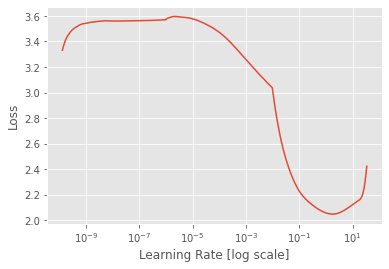

In [ ]:
lrf.plot_loss(skip_end = 40)

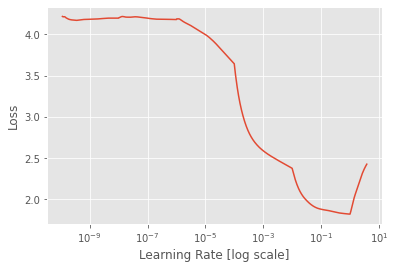

In [ ]:
lrf.plot_loss(skip_end = 250)

In [ ]:
# step decay learning rate scheduler
def lr_sched(epoch):
    lr = init_lr

    if epoch < 1:
        lr = init_lr / 10
    elif epoch < 90:
        lr = init_lr
    elif epoch < 135:
        lr = init_lr / 10
    else:
        lr = init_lr / 100
    
    return lr

# # cosine decay learning rate scheduler
# class CosineScheduler(Callback):
#     def __init__(self, max_lr, steps_per_epoch, tot_epochs, warmup = 5):
#         # parent class constructor
#         super(CosineScheduler, self).__init__()

#         # initialize the instance variables
#         self.max_lr = max_lr
#         self.warm_steps = steps_per_epoch * warmup
#         self.reg_steps = steps_per_epoch * (tot_epochs - warmup)
#         self.history = {"lrs" : []}
    
#     def on_train_begin(self, logs = None):
#         # initialize a counter to keep track of the number of batches seen
#         self.iterations = 0
    
#     def on_batch_begin(self, batch, logs = None):
#         # increment the number of iterations
#         self.iterations += 1

#         # calculate the learning rate
#         if self.iterations <= self.warm_steps:
#             lr = (self.iterations / self.warm_steps) * self.max_lr
#         else:
#             lr = (self.max_lr / 2.0) * (1 + np.cos(((self.iterations - self.warm_steps) / self.reg_steps) * np.pi))
        
#         # update the learning rate
#         K.set_value(self.model.optimizer.lr, lr)

#         # add the current learning rate to the history dictionary
#         self.history["lrs"].append(lr)

In [ ]:
# initialize the callbacks
mc = ModelCheckpoint(os.path.sep.join(["models", model_name + "_{epoch:03d}.h5"]))
tm = TrainingMonitor(f"{model_name}.png", f"{model_name}.json")
lr = LearningRateScheduler(lr_sched)
# cs = CosineScheduler(init_lr, steps_per_epoch, epochs)
callbacks = [mc, tm, lr]

In [ ]:
# initialize the model and compile it
model = MODELS[model_name]
opt = SGD(lr = init_lr, momentum = 0.9)
# loss = CategoricalCrossentropy(label_smoothing = 0.1)
loss = CategoricalCrossentropy()
model.compile(optimizer = opt, loss = loss, metrics = ["accuracy"])

In [ ]:
# train the model
model.fit_generator(train_datagen, steps_per_epoch = steps_per_epoch, epochs = epochs,
                    validation_data = val_datagen, validation_steps = validation_steps,
                    callbacks = callbacks)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/180
352/352 [==============================] - 25s 70ms/step - loss: 1.8355 - accuracy: 0.3941 - val_loss: 1.5371 - val_accuracy: 0.4888 - lr: 0.0100
Epoch 2/180
352/352 [==============================] - 24s 69ms/step - loss: 1.4631 - accuracy: 0.5276 - val_loss: 1.1503 - val_accuracy: 0.6460 - lr: 0.1000
Epoch 3/180
352/352 [==============================] - 24s 69ms/step - loss: 1.0839 - accuracy: 0.6761 - val_loss: 1.0522 - val_accuracy: 0.6844 - lr: 0.1000
Epoch 4/180
352/352 [==============================] - 24s 69ms/step - loss: 0.9218 - accuracy: 0.7401 - val_loss: 1.1958 - val_accuracy: 0.6694 - lr: 0.1000
Epoch 5/180
352/352 [==============================] - 24s 69ms/step - loss: 0.8299 - accuracy: 0.7721 - val_loss: 1.0223 - val_accuracy: 0.7194 - lr: 0.1000
Epoch 6/180
352/352 [==============================] - 24s 68ms/step - loss: 0.7678 - accuracy: 0.7958 - val_loss: 0.8337 - val_accura

# INFERENCE #

In [ ]:
# load the trained model
test_model = load_model(f"models/{model_name}_{epochs}.h5", custom_objects = {"Downsample" : Downsample, "Mish" : Mish})

# initialize the data generator
test_gen = CifarGenerator(x_test, y_test, bs, preprocessors = [mp, iap]).generator()

# evaluate the model
H = test_model.evaluate_generator(test_gen, steps = test_steps)
print(H)

Instructions for updating:
Please use Model.evaluate, which supports generators.
[0.5172573924064636, 0.921500027179718]


# INSPECTION #

In [ ]:
def get_layer_index(model, name):
    for i, layer in enumerate(model.layers):
        if(layer.name == name):
            return i

In [ ]:
def calc_cosine_similarity(x):
    x = np.reshape(x, (x.shape[-1], -1))
    norms = np.linalg.norm(x, axis = -1, keepdims = True)
    xn = x / (norms + 1e-6)
    grad = np.matmul(xn, np.transpose(xn))
    grad = (180 / np.pi) * np.arccos(grad)
    
    grad = grad * (1 - np.eye(grad.shape[1], dtype = grad.dtype))

    grad = (1 / (grad.shape[0] - 1)) * np.sum(grad, axis = -1)    

    return np.min(grad)

In [ ]:
metrics = {}
# loop through the stages
for i in range(1, 4):
    # loop through the blocks
    for j in range(1, 4):
        # loop through the conv layers
        for k in range(1, 3):
            # define the layer name and grab the layer
            layer = f"stage{i}_res_block{j}_conv{k}"

            # grab the appropriate layers
            prior_dist_layer = test_model.layers[get_layer_index(model, layer)]

            # grab the weights and calculate the cosine similarity
            x = prior_dist_layer.get_weights()[0]
            metrics[layer] = np.round(calc_cosine_similarity(x), 2)

np.set_printoptions(precision = 3)
print(np.mean(list(metrics.values())))

In [ ]:
function ClickConnect(){
    document.querySelector('#top-toolbar > colab-connect-button').shadowRoot.querySelector('#connect').click()
    console.log("Working");
}
setInterval(ClickConnect, 60000)

# 29259

In [ ]:
! rm -r models
! rm xresnet20.json
! rm xresnet20.png

# TEMP #

In [ ]:
w = np.random.randn(64)
lamb = np.random.randn(64)
# 64 -> 64x64 -> 64

In [ ]:
new_w = np.repeat(w[..., np.newaxis], 64, axis = -1)
dist = np.sqrt(np.mean(np.square(new_w - new_w.T), axis = -1))

In [ ]:
w_ = w - (1e-1 / dist)

In [ ]:
np.linalg.norm(w_ - w)

In [ ]:
from tensorflow.keras.layers import Reshape

In [ ]:
class Repeat(Layer):
    def __init__(self):
        super(Repeat, self).__init__()
    
    def call(self, x):
        return K.repeat(x, x.shape[-1])

In [ ]:
class Dist(Layer):
    def __init__(self):
        super(Dist, self).__init__()
    
    def call(self, x):
        return tf.math.reduce_mean(tf.math.abs(tf.math.subtract(x, tf.transpose(x, perm = [0, 2, 1]))), axis = -1)

In [ ]:
# class Shift(Layer):
#     def __init__(self, lamb):
#         super(Shift, self).__init__()
#         self.lamb = lamb

#     def call(self, x):
#         print(tf.divide(self.lamb, x[1]).shape)
#         return tf.subtract(x[0], tf.divide(self.lamb, x[1]))

class Shift(Layer):
    def __init__(self, dhist, mom = 0.9):
        super(Shift, self).__init__()
        self.mom = mom
        self.dhist = dhist

    def build(self, input_shape):
        self.kernel = self.add_weight("kernel", shape = [input_shape[1][-1]])

    def call(self, x):
        if tf.equal(self.dhist, tf.zeros(self.dhist.shape)):
            tf.compat.v1.assign(self.dhist, x[1])
            return tf.subtract(x[0], tf.divide(tf.math.square(self.kernel), x[1]))
        else:
            d_ = tf.math.add(tf.math.multiply(self.mom, self.dhist), tf.math.multiply(1 - self.mom, x[1]))
            tf.compat.v1.assign(self.dhist, x[1])

            return tf.subtract(x[0], tf.divide(tf.math.square(self.kernel), d_))
    
    def get_config(self):
        return {"mom" : float(self.mom)}

In [ ]:
def rds_block(x, bs = 128):
    shortcut = x
    
    x = GlobalAveragePooling2D()(x)
    x = Repeat()(x)
    x = Dist()(x)
    x = Reshape((1, 1, x.shape[1]))(x)
    x = Shift(tf.Variable(initial_value = tf.zeros((bs, 1, 1, x.shape[-1])), trainable = False), mom = 0.9)([shortcut, x])

    return x

In [ ]:
class SimilarityPenalizer(Regularizer):
    def __init__(self, lamb):
        super(SimilarityPenalizer, self).__init__()
        self.lamb = lamb
    
    def __call__(self, x):
        # x = tf.reshape(x, (-1, x.shape[-1]))
        # mu = tf.math.reduce_mean(x, axis = 0, keepdims = True)

        # x_ = x - mu
        # x_ = tf.reshape(x_, (x_.shape[0], x_.shape[1], 1))
        # x_ = tf.repeat(x_, x_.shape[1], axis = -1)

        # C  = (1 / x_.shape[0]) * tf.reduce_sum(tf.multiply(x_, tf.transpose(x_, perm = (0, 2, 1))), axis = 0)

        # dist = (1 / 2) * (tf.norm(C) - tf.norm(tf.linalg.diag_part(C)))

        # return (self.lamb * dist)

        x = tf.reshape(x, (x.shape[-1], -1))
        x = x / (tf.linalg.norm(x, axis = -1, keepdims = True))
        cs = tf.matmul(x, tf.transpose(x))
        cs = cs * (1.0 - tf.eye(cs.shape[0], dtype = cs.dtype))

        dist = tf.reduce_sum(tf.math.log(1.0 + tf.exp(10.0 * (cs - 1.0))))

        # x = tf.reshape(x, (-1, x.shape[-1], 1))
        # x = tf.repeat(x, x.shape[1], axis = -1)
        # x = tf.math.l2_normalize(x, axis = 0)
        # xt = tf.transpose(x, perm = (0, 2, 1))

        # cs = tf.reduce_sum(tf.multiply(x, xt), axis = 0)
        # cs = tf.subtract(cs, tf.eye(cs.shape[0], dtype = "double"))

        # dist = tf.reduce_sum(tf.math.log(tf.add(tf.constant(1, dtype = tf.float64), tf.exp(tf.constant(10, dtype = tf.float64) * (tf.subtract(cs, 1))))))

        return self.lamb * dist
    
    def get_config(self):
        return {"lamb" : float(self.lamb)}

In [ ]:
class NegReg(Regularizer):
    def __init__(self, reg, eta):
        super(NegReg, self).__init__()
        self.reg = reg
        self.eta = eta
    
    def __call__(self, x):
        x = tf.reshape(x, (x.shape[-1], -1))
        x = x / tf.linalg.norm(x, axis = -1, keepdims = True)
        cs = tf.matmul(x, tf.transpose(x))
        cs = cs - self.eta * (tf.eye(cs.shape[0], dtype = cs.dtype) - tf.ones_like(cs, dtype = cs.dtype))

        cs = cs * (1 - tf.eye(cs.shape[0], dtype = cs.dtype))
        dist = tf.linalg.norm(cs)

        return self.reg * dist

In [ ]:
x = np.random.randn(3, 3, 16, 64)
x = tf.reshape(x, (x.shape[-1], -1))
x = x / (tf.linalg.norm(x, axis = -1, keepdims = True))
cs = tf.matmul(x, tf.transpose(x))
cs = cs * (1.0 - tf.eye(cs.shape[0], dtype = cs.dtype))

dist = tf.reduce_sum(tf.math.log(1.0 + tf.exp(10.0 * (cs - 1.0))))

print(dist)

In [ ]:
class ActivityRegularizer(Regularizer):
    def __init__(self, lamb):
        super(ActivityRegularizer, self).__init__()
        self.lamb = lamb
    
    def __call__(self, x):
        x_ = tf.reduce_mean(x, axis = (1, 2))
        x_ = tf.reshape(x_, (-1, x_.shape[1], 1))
        x_ = tf.repeat(x_, x_.shape[-2], axis = -1)

        dist = tf.reduce_mean(tf.abs(tf.subtract(x_, tf.transpose(x_, perm = (0, 2, 1)))))

        return (self.lamb / dist)

    def get_config(self):
        return {"lamb" : self.lamb}

In [ ]:
class Downsample(Layer):
    def __init__(self, filt_size = 3, stride = 2, pad_off = 0, **kwargs):
        super(Downsample, self).__init__(**kwargs)
        self.filt_size = filt_size
        self.stride = stride
        self.pad_off = pad_off

        # pad sizes: LEFT, RIGHT, TOP, BOTTOM
        self.pad_sizes = [int(1. * (filt_size - 1) / 2), int(np.ceil(1. * (filt_size - 1) / 2)), int(1. * (filt_size - 1) / 2), int(np.ceil(1. * (filt_size - 1) / 2))]
        self.pad_sizes = [pad_size + pad_off for pad_size in self.pad_sizes]

    def build(self, input_shape):
        # initialize the appropriate blur kernel
        if(self.filt_size == 1):
            a = np.array([1.,])
        elif(self.filt_size == 2):
            a = np.array([1., 1.])
        elif(self.filt_size == 3):
            a = np.array([1., 2., 1.])
        elif(self.filt_size == 4):    
            a = np.array([1., 3., 3., 1.])
        elif(self.filt_size == 5):    
            a = np.array([1., 4., 6., 4., 1.])
        elif(self.filt_size == 6):    
            a = np.array([1., 5., 10., 10., 5., 1.])
        elif(self.filt_size == 7):
            a = np.array([1., 6., 15., 20., 15., 6., 1.])
        
        # compute the outer product to get the final filter
        filt = np.outer(a, a)
        filt = filt / np.sum(filt)

        # kernel shape
        kernel_shape = (self.filt_size, self.filt_size, input_shape[3], 1)

        # reshape the filter into the appropriate shape and create the initializer
        filt = np.repeat(filt, input_shape[3])
        filt = np.reshape(filt, kernel_shape)
        blur_init = keras.initializers.constant(filt)

        # create the blur kernel
        self.kernel = self.add_weight("kernel", shape = kernel_shape, initializer = blur_init, trainable = False)

        # call the parent class constructor
        super(Downsample, self).build(input_shape)
    
    def call(self, x):
        if self.filt_size == 1:
            if self.pad_off == 0:
                return x[:, ::self.stride, ::self.stride, :]
            else:
                x = tf.pad(x, paddings = tf.constant([[0, 0], self.pad_sizes[2:], self.pad_sizes[:2], [0, 0]]), mode = "REFLECT")
                return x[:, ::self.stride, ::self.stride, :]
        else:
            # pad the input (reflect pad)
            x = tf.pad(x, paddings = tf.constant([[0, 0], self.pad_sizes[2:], self.pad_sizes[:2], [0, 0]]), mode = "REFLECT")
            return K.depthwise_conv2d(x, self.kernel, strides = (self.stride, self.stride))

In [ ]:
# initialize the dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# split the dataset into the train and validation splits
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train,
                                                  test_size = 0.1, random_state = 42,
                                                  stratify = y_train)

x_train = x_train.astype("float") / 255.0
y_train = LabelBinarizer().fit_transform(y_train)

In [ ]:
inpt = Input(shape = (32, 32, 3))
x = Conv2D(32, (3, 3), padding = "same")(inpt)
x = MaxPooling2D(pool_size = (3, 3), strides = (1, 1))(x)
x = Downsample(filt_size = 3, stride = 3)(x)
# x = rds_block(x)
x = Activation("relu")(x)
x = Flatten()(x)
x = Dense(10, activation = "softmax")(x)

temp_model = Model(inputs = inpt, outputs = x)

In [ ]:
temp_model.summary()

In [ ]:
temp_model.compile(loss = "categorical_crossentropy", optimizer = "sgd", metrics = ["accuracy"])

In [ ]:
temp_model.fit(x_train, y_train, epochs = 5, batch_size = 128)